In [42]:
!pip install lightgbm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

In [92]:
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

### few quick observations

We can make few observations based on the data description in the competition:

- Few groups are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably individual, reg is probably registration, car is self-- explanatory, calc suggests a calculated field;
- The postfix bin is used for binary features;
- The postfix cat to is used for categorical features;
- Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
- A missing value is indicated by -1;
- The value that is subject of prediction is in the target column. This one indicates whether or not a - claim was filed for that insured person;
- id is a data input ordinal number.


Let's glimpse the data to see if these interpretations are confirmed.

In [93]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [94]:
print(trainset.shape)
print(testset.shape)

(595212, 59)
(892816, 58)


In [95]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

### introduction of metadata

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a category field for the car, ind, reg and calc types of features.

What metadata will be used:

- use: input, ID, target
- type: nominal, interval, ordinal, binary
- preserve: True or False
- dataType: int, float, char
- category: ind, reg, car, calc

In [96]:
data = []
for feature in trainset.columns:
    # defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == 'float64':
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
        
    # initialize preserve to true for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
        
    # defining the data type
    dtype = trainset[feature].dtype
    
    category = 'none'
    # defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    
    # creating a dick that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace = True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [97]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [98]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [99]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


### data analysis and statistics

target variable

<Figure size 432x288 with 0 Axes>

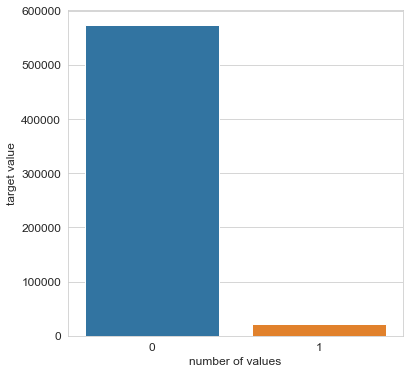

In [100]:
plt.figure()
f, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# bar plot
# order the bars descending on target mean
sns.barplot(x, y, ax=ax)
plt.xlabel('number of values', fontsize=12)
plt.ylabel('target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

- Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced. We can either undersample the records with target = 0 or oversample records with target = 1; because is a large dataset, we will do undersampling of records with target = 0.

In [101]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [102]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [103]:
pow(trainset['ps_car_15'], 2).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

Features with missing values<br/>
- ps_reg_o3, ps_car_12, ps_car_14 have missing values (their minimum value is -1)


Registration features<br/>
- ps_reg_01 and ps_reg_02 are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )


Car features<br/>
- ps_car_12 are (with some approximations) square roots (divided by 10) of natural numbers whilst - ps_car_15 are square roots of natural numbers. Let's represent the values using pairplot.

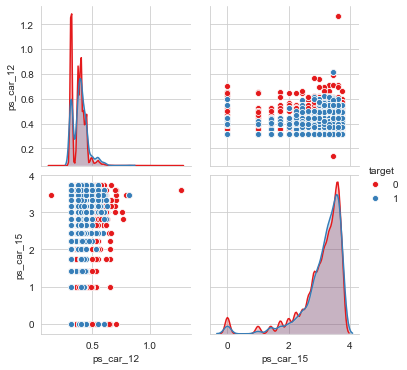

In [104]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Calculated features

The features ps_calc_01, ps_calc_02 and ps_calc_03 have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9. The other calculated values have maximum value an integer value (5,6,7, 10,12).

Let's visualize the real features distribution using density plot.

<Figure size 432x288 with 0 Axes>

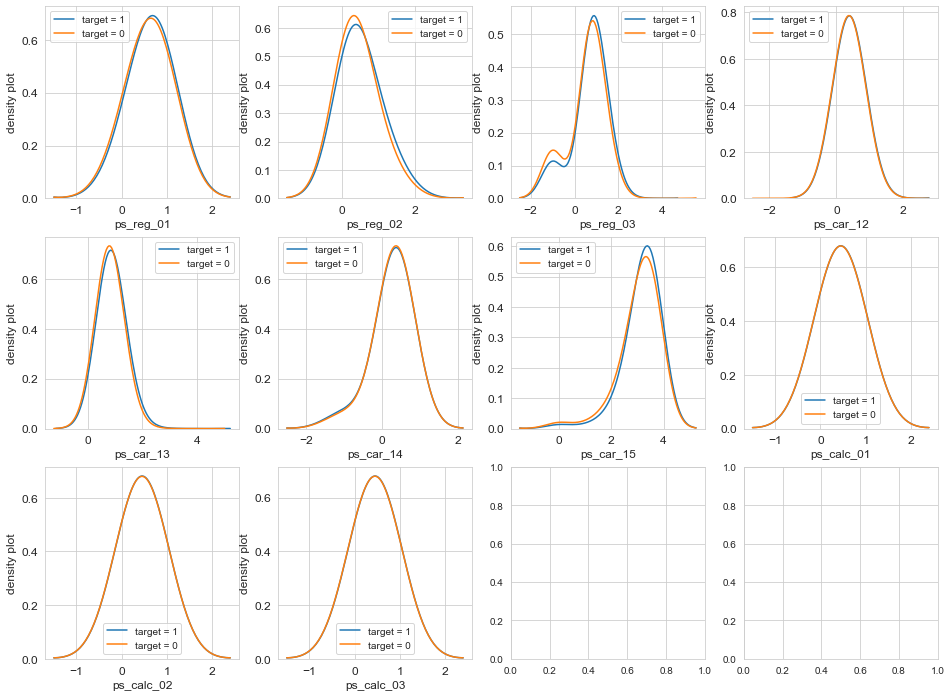

In [105]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
f, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_reg_02, ps_car_13, ps_car_15 shows the most different distributions between sets of values associated with target=0 and target=1.

Let's visualize the correlation between the real features

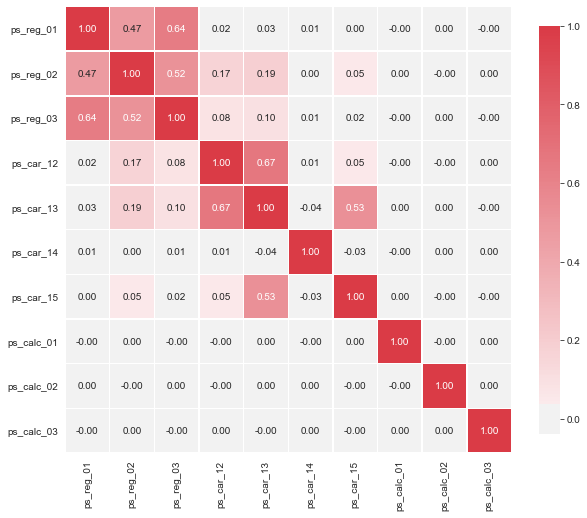

In [106]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1, center=0, fmt='.2f', square=True, linewidths=.5,
               annot=True, cbar_kws={'shrink': .75})
    
    plt.show()

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are:

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.

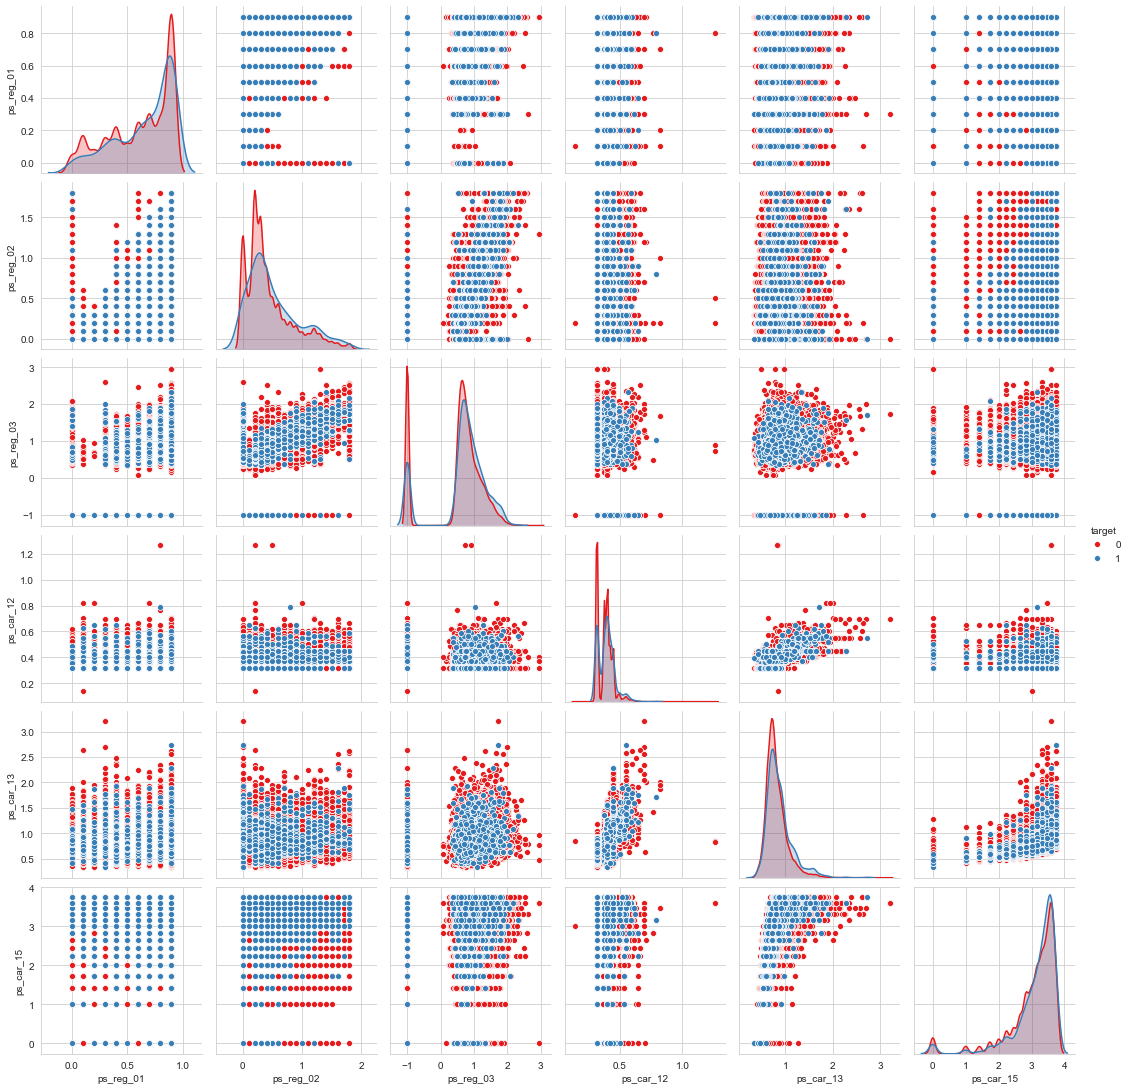

In [107]:
sample = trainset.sample(frac = 0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### binary features

In [108]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the distribution of the binary data in the training dataset. With blue we represent the percent of 0 and with red the percent of 1.

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x0000023124412E88> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

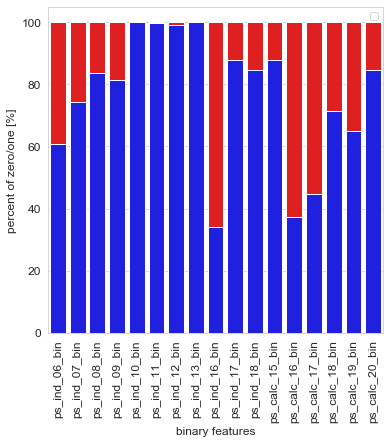

In [109]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((trainset[col] == 0).sum() / trainset.shape[0]*100)
    one_list.append((trainset[col] == 1).sum() / trainset.shape[0]*100)
plt.figure()
f, ax = plt.subplots(figsize=(6, 6))

# bar plot
p1 = sns.barplot(bin_col, zero_list, color='blue')
p2 = sns.barplot(bin_col, one_list, color='red', bottom=zero_list)
plt.ylabel('percent of zero/one [%]', fontsize=12)
plt.xlabel('binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin have very small number of values 1 (lesss than 0.5%) whilst the number of value 1 is very large for ps_ind_16_bin and ps_cals_16_bin (more than 60%).

Let's see now the distribution of binary data and the corresponding values of target variable.

<Figure size 432x288 with 0 Axes>

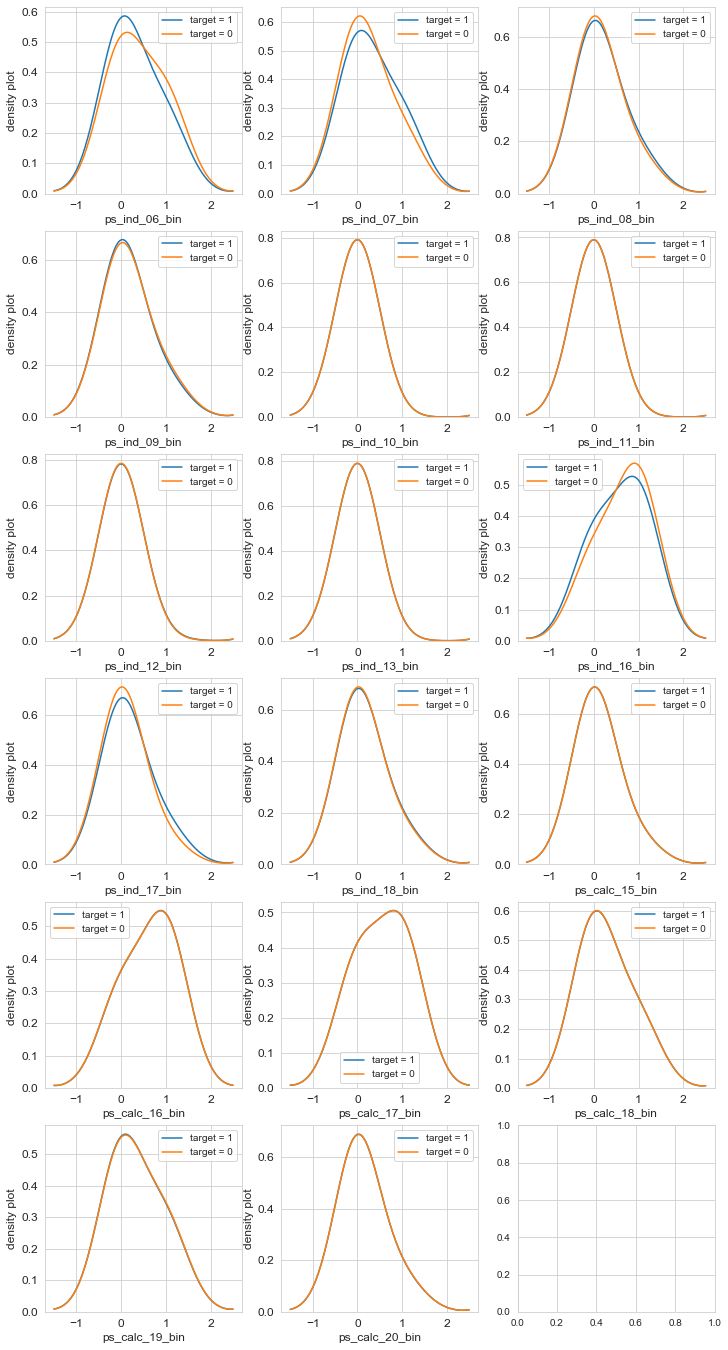

In [110]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
f, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, label = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin shows high inbalance between distribution of values of 1 and 0 for values of target equals with 1 and 0, ps_ind_08_bin shows a small inbalance while the other features are well balanced, having similar density plots.

### Categorical features


We will represent the distribution on categorical data in two ways. First, we calculate the percentage of target=1 per category value and represent these percentages using bar plots.

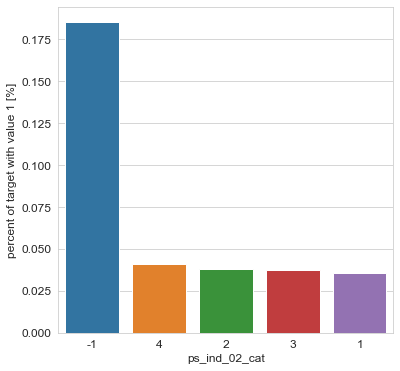

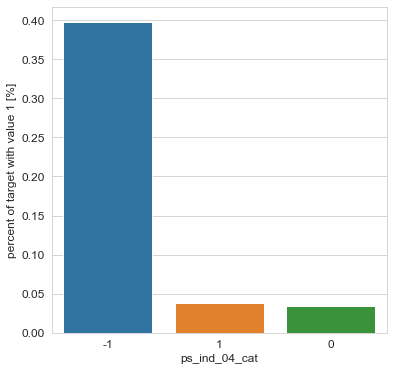

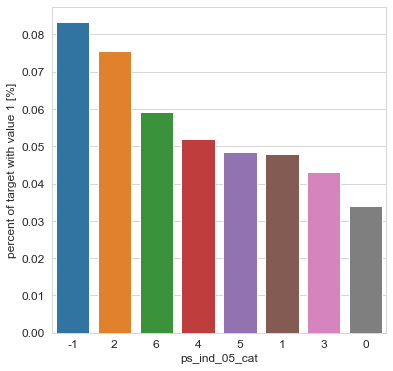

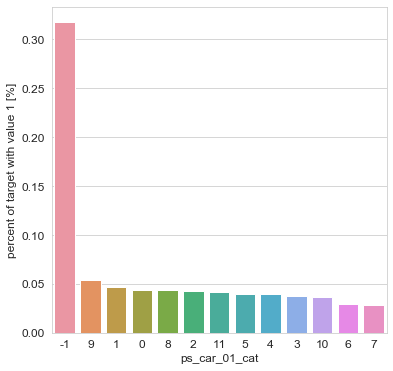

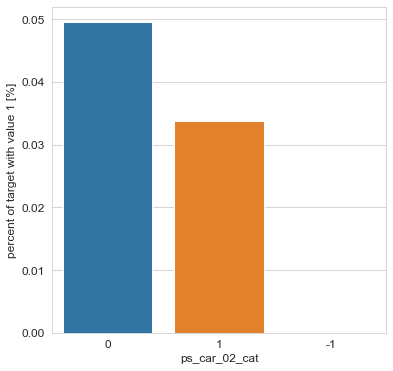

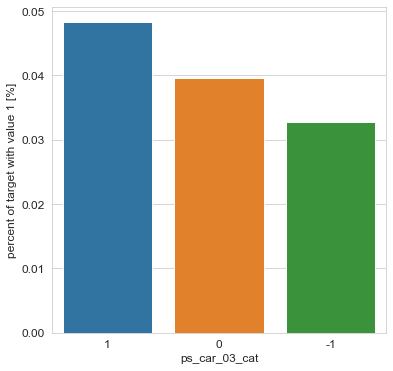

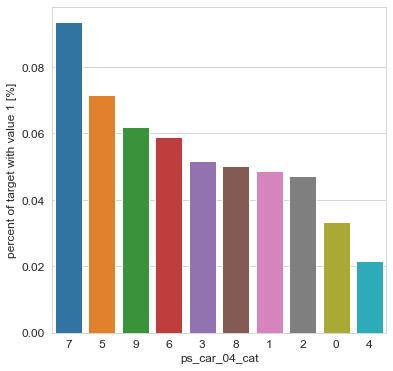

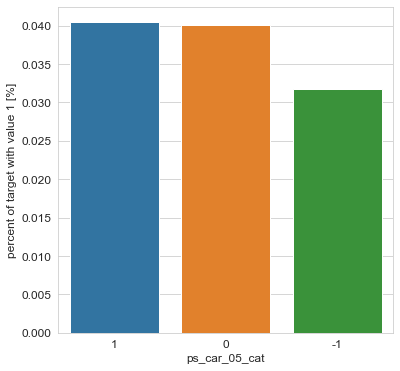

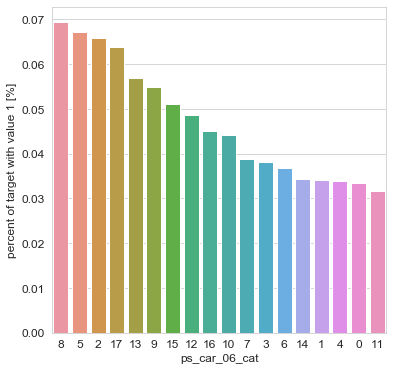

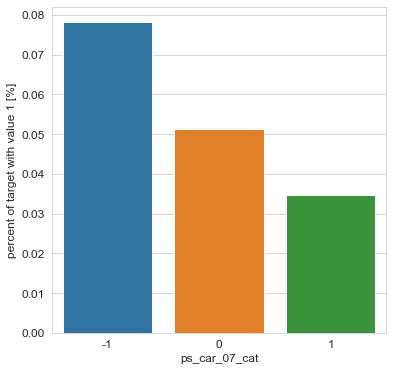

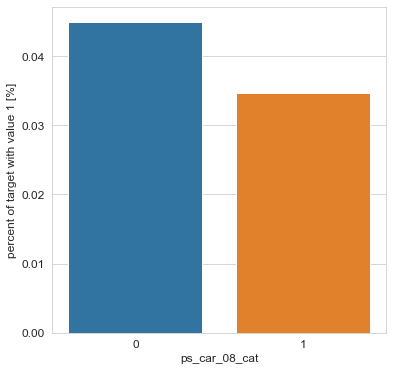

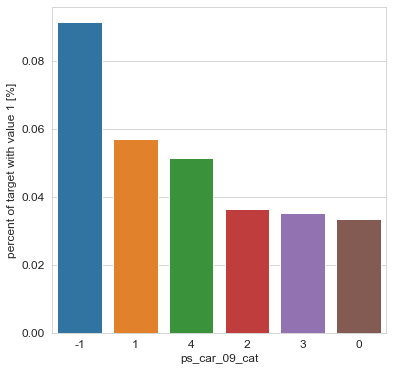

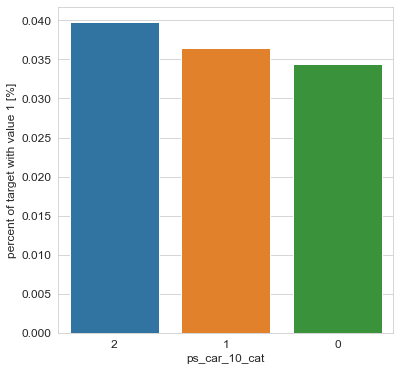

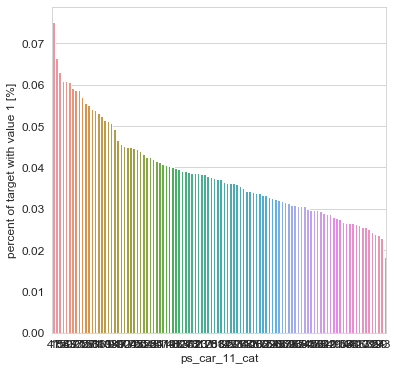

In [111]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    f, ax = plt.subplots(figsize=(6, 6))
    
    # calculate the percentage of target=1, per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # bar plot. order the bars descending on target mean
    sns.barplot(feature, 'target', ax=ax, data=cat_perc, order=cat_perc[feature])
    
    plt.ylabel('percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

Alternativelly we represent the categorical features using density plot. We select values with target=0 and target=1 and represent both density plots on the same graphic.

<Figure size 432x288 with 0 Axes>

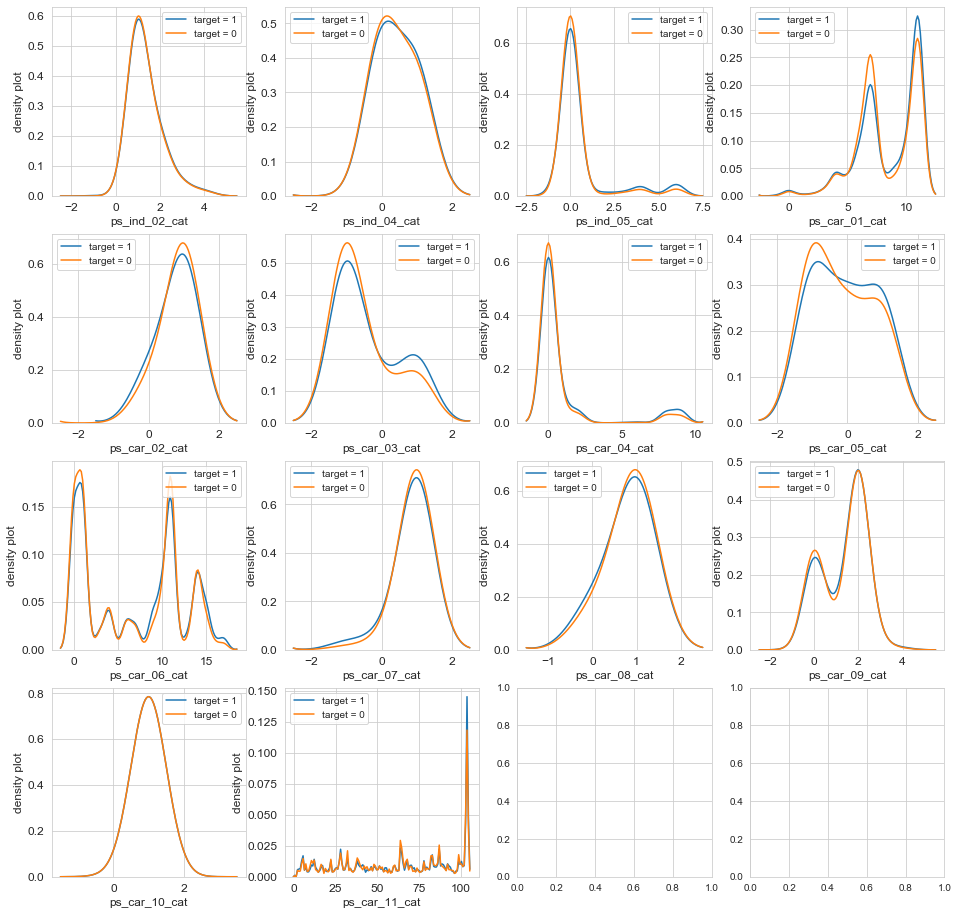

In [112]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
f, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

ps_car_03_cat, ps_car_05_cat shows the most different density plot between values associated with target=0 and target=1.

### Data unbalance between train and test data

Let's compare the distribution of the features in the train and test datasets.

We start with the reg or registration features.

<Figure size 432x288 with 0 Axes>

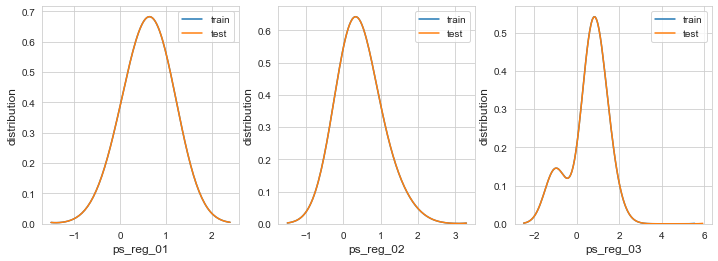

In [113]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# bar plot
sns.set_style('whitegrid')

plt.figure()
f, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
#     locs, labels = plt.xticks()
#     plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


all reg features shows well balanced train and test sets.
let's continue with car features.

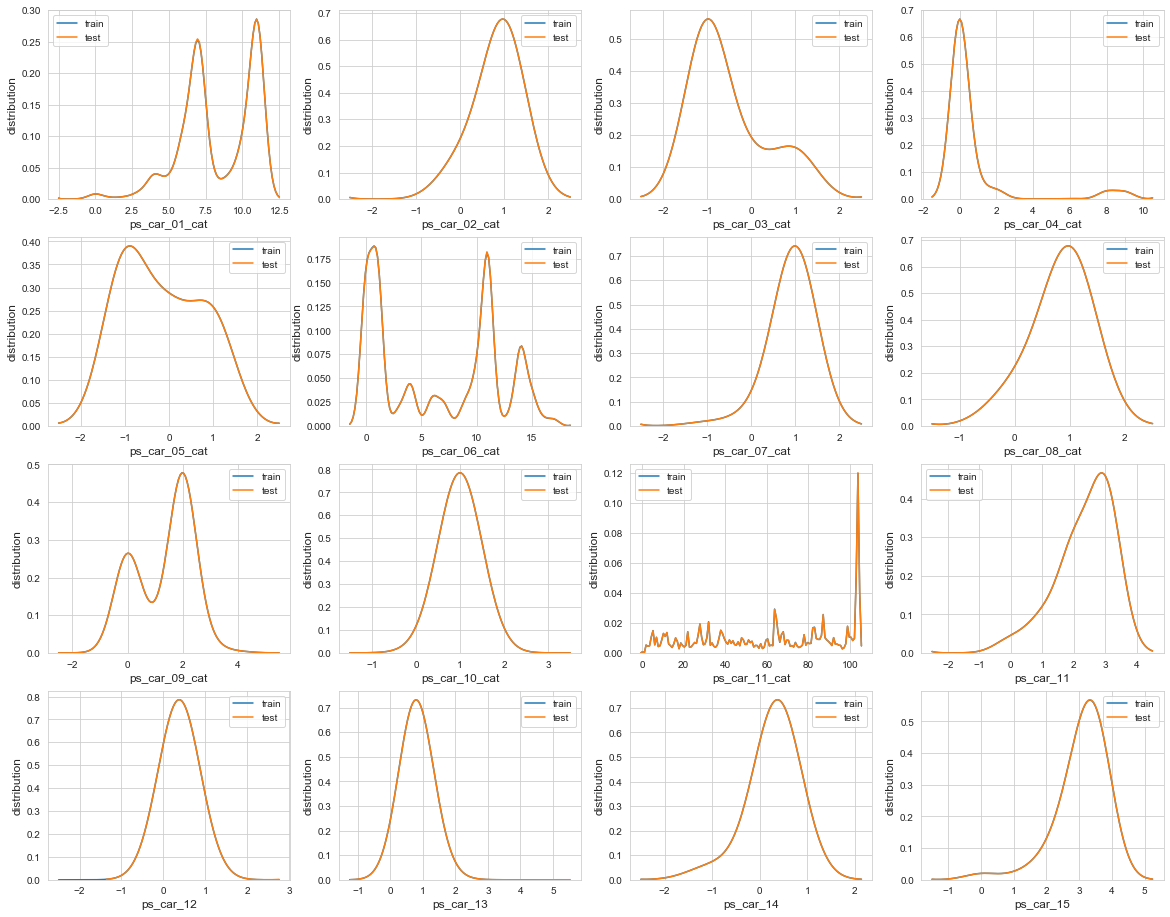

In [114]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# bar plot
f, ax = plt.subplots(4, 4, figsize=(20,16))
i = 0

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)

plt.show()

From the car features, all variables looks well balanced between train and test set.

Let's look now to the ind (individual) values.

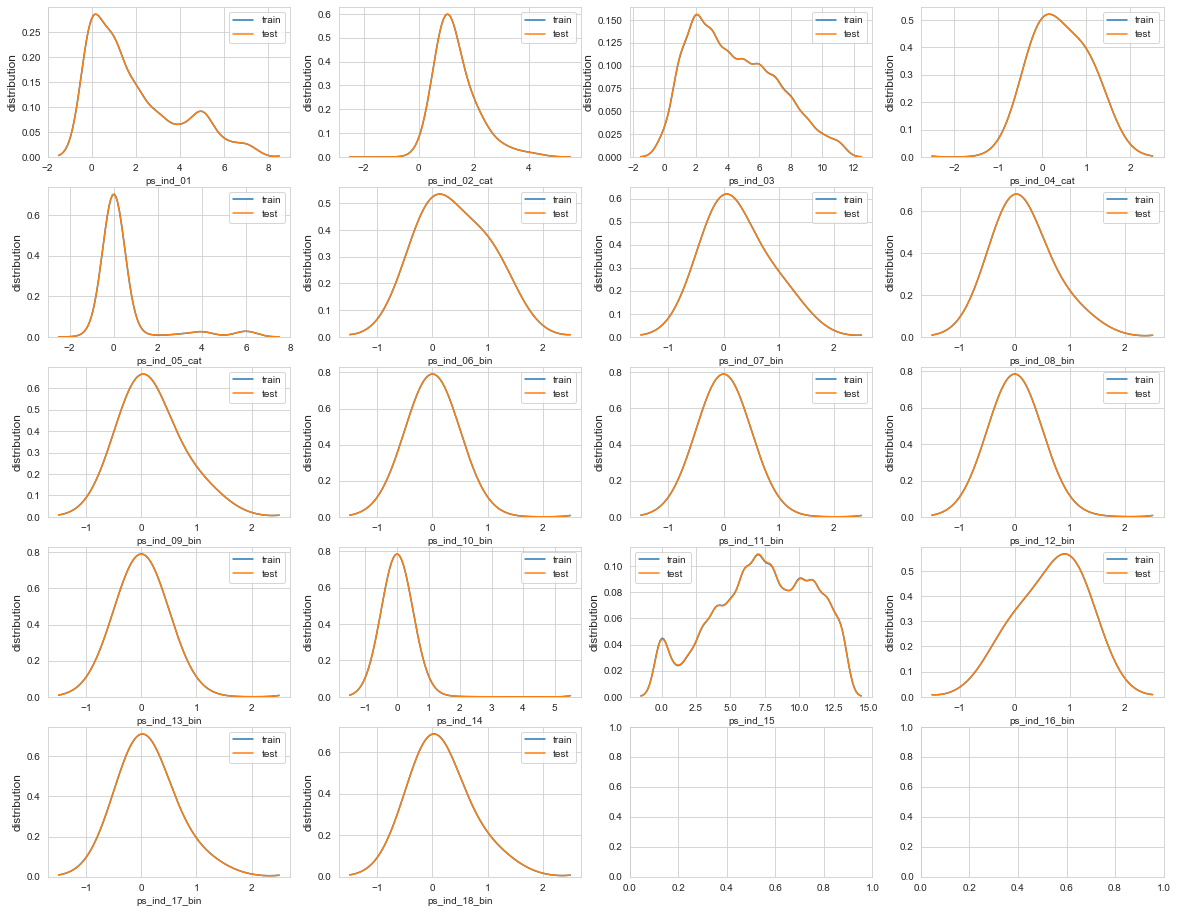

In [115]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

f, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature)
plt.show()

All ind features are well balanced between train and test sets.

Let's check now calc features.

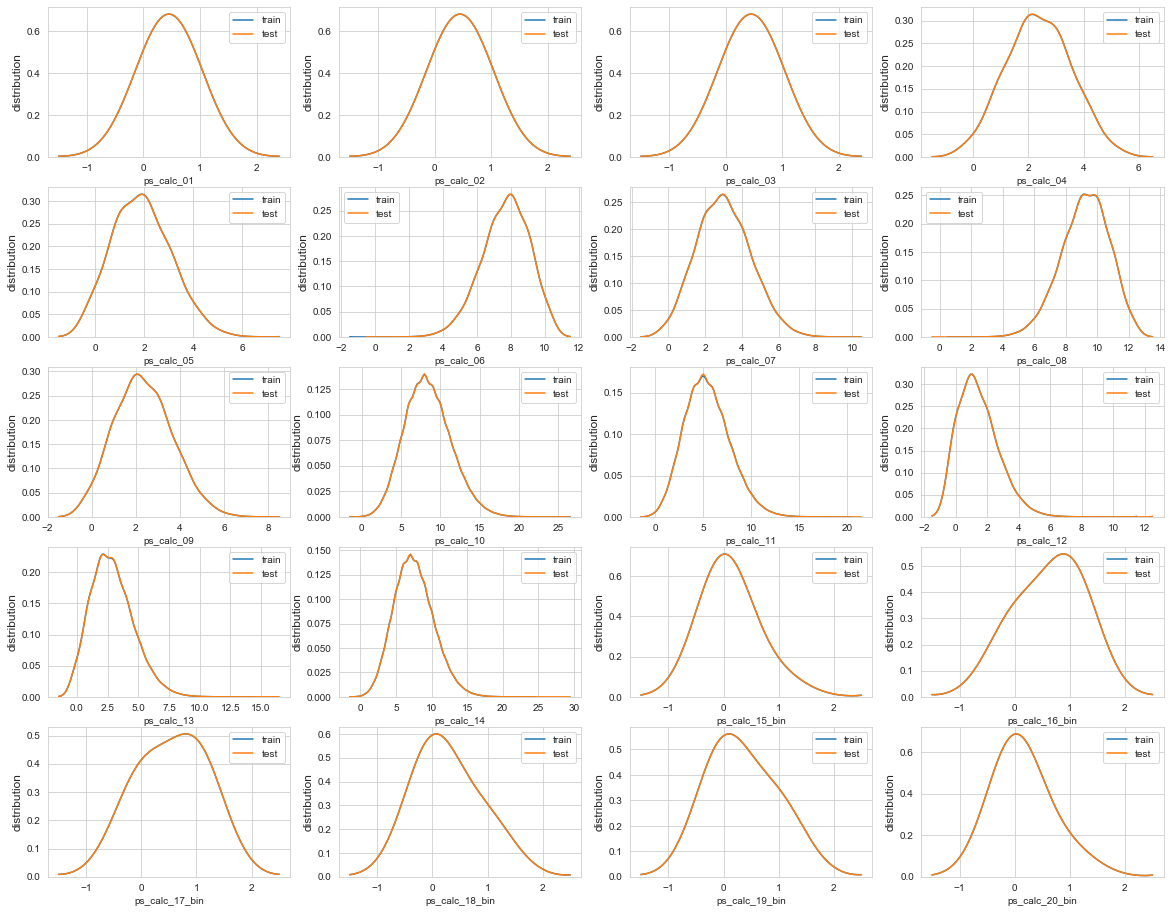

In [116]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

f, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature)
plt.show()

All calc features are well balanced between train and test sets.

In reference [5] it is also noticed the well balancing between train and test sets. It is also suggested that calc features might be all engineered and actually not relevant. This can only be assesed by careful succesive elimination using CV score using one or more predictive models.

### check data quality

let's ispect the features with missing values

In [117]:
var_with_missing = []

for feature in trainset.columns:
    missing = trainset[trainset[feature] == -1 ][feature].count()
    if missing > 0:
        var_with_missing.append(feature)
        missing_perc = missing/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missing,
                                                                               missing_perc))

print('in total, there are {} variables with missing values'.format(len(var_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
in total, there are 13 variables with missing values


### prepare the data for model

drop calc columns
We also drop the calc columns, as recommended in [5]. These seems to be all engineered and, according to Dmitry Altukhov, he was able to improve his CV score while succesivelly removing all of them.

In [118]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

Drop variables with too many missing values

We select from the variables with missing values two, ps_car_03_cat and ps_car_05_cat to drop.

In [119]:
# dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'keep'] = False # updating the meta

In [120]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # apply averages to trn and tst serise
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

Replace ps_car_11_cat with encoded value

Using the target_encode function, we replace the ps_car_11_cat with an encoded value in both train and test datasets.

In [121]:
train_encoded, test_encoded, = target_encode(trainset['ps_car_11_cat'],
                                            testset['ps_car_11_cat'],
                                            target=trainset.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

trainset['ps_car_11_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False # updating metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

Balance target variable


The target variable is highly unbalanced. This can be improved by either undersampling values with target = 0 or oversampling values with target = 1. Because there is a rather large training set, we opt for the undersampling.

In [122]:
desired_apriori=0.1

# get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1 - desired_apriori) * nb_1)/(nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state = 0, n_samples=undersampled_nb_0)

# construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


Replace -1 values with NaN

Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.

In [123]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

Dummify cat values

We will create dummy variables for the categorical (cat) features

In [124]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

Drop unused and target columns


We separate the id and target (drop these columns)

In [125]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

let's inspect the training and test sets:

In [126]:
print("Train dataset (rows, cols):", trainset.values.shape, 
      "\nTest dataset (rows, cols):", testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


### Prepare the model

Ensable class for cross validation and ensamble
Prepare an Ensamble class to split the data in KFolds, train the models and ensamble the results.

The class has an init method (called when an Ensamble object is created) that accepts 4 parameters:

- self - the object to be initialized
- n_splits - the number of cross-validation splits to be used
- stacker - the model used for stacking the prediction results from the trained base models
- base_models - the list of base models used in training

A second method, fit_predict has four functions:

- split the training data in n_splits folds;
- run the base models for each fold;
- perform prediction using each model;
- ensamble the resuls using the stacker;

In [127]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        # StratifiedKFold로 나오는 값을 리스트로 만듬
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=0).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                
                # test_idx에 i번째
                # splits가 5번이면 5번을 다 돌면 모든 인덱스가 다 나옴

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=5, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        # stacker에 test를 진행한 결과를 리턴함. 이게 최종값(결과값)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [128]:
# LightGBM params
# lgb1
lgb_params1 = {
    'learning_rate': 0.02,
    'n_estimators': 650,
    'max_bin': 10,
    'subsample': 0.8,
    'subsample_freq': 10,
    'colsample_bytree': 0.8,
    'min_child_samples': 500,
    'seed': 0,
    'num_threads': 4
}

# lgb2
lgb_params2 = {
    'n_estimators': 1090,
    'learning_rate': 0.02,
    'colsample_bytree': 0.3,
    'subsample': 0.7,
    'subsample_freq': 2,
    'num_leaves': 16,
    'seed': 0,
    'num_threads': 4
}

# lgb3
lgb_params3 = {
    'n_estimators': 1100,
    'max_depth': 4,
    'learning_rate': 0.02,
    'seed': 0,
    'num_threads': 4
}

# XGboost params
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.04,
    'n_estimators': 490,
    'max_depth': 4,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 10,
    'num_threads': 4
}

Initialize the models with the parameters


We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.

In [129]:
# base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# stacking model
log_model = LogisticRegression()

Initialize the ensambling object


Using Ensamble.init we init the stacking object

In [130]:
stack = Ensemble(n_splits=5, 
                 stacker=log_model, 
                 base_models=(lgb_model1, lgb_model2, lgb_model3, xgb_model))

### Run the predictive models
Calling the fit_predict method of stack object, we run the training of the base models, predict the target with each model, ensamble the results using the stacker model and output the stacked result.

In [131]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63951 [gini]: 0.27902
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63940 [gini]: 0.27879
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.64033 [gini]: 0.28066
Base model 1: fit LGBMClassifier model | fold 4
cross_score [roc-auc]: 0.64050 [gini]: 0.28100
Base model 1: fit LGBMClassifier model | fold 5
cross_score [roc-auc]: 0.64209 [gini]: 0.28419
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.64059 [gini]: 0.28118
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63934 [gini]: 0.27868
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.64125 [gini]: 0.28250
Base model 2: fit LGBMClassifier model | fold 4
cross_score [roc-auc]: 0.64093 [gini]: 0.28187
Base model 2: fit LGBMClassifier model | fold 5
cross_score [roc-auc]: 0.64289 [gini]: 0.28577
Base model 3: fit LGBMClassifier model | fold 1
cr